In [1]:
#Supressing warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


#Model fitting packges
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import RFE
from scipy import stats
from scipy.stats import norm, skew

In [3]:
pd.set_option("max_columns", None)
pd.set_option("max_rows", None)

In [4]:
#Reading the dataset
df = pd.read_csv("train.csv")

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.shape

(1460, 81)

We can drop the id column.

In [7]:
df_id = df["Id"]
df.drop("Id", axis = 1, inplace = True)

### Before proceeding with the exploratory data analysis, I could see that we need to correct the datatype of the following columns: - 
- MSSubClass is represented as integer but it is actually a categorical variable
- The following columns should have the datatype of datetime instead of integer: -
    - Year Build
    - Month Sold (We'll convert this to Month Names)

We will change the datatype of these variables for now
And we will handle the years later

In [8]:
df["MSSubClass"] = df["MSSubClass"].astype("str")
df["MoSold"] = pd.to_datetime(df["MoSold"], format = "%m").apply(lambda x: str(x.strftime("%B")))

In [9]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,February,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,May,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,September,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,February,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,December,2008,WD,Normal,250000


### Looking at the composition of the variables

In [10]:
#Number of numerical variables :-
len(list(df.select_dtypes("int64").columns) +list(df.select_dtypes("float").columns))

35

In [11]:
# Number of categorical variables : -
len(list(df.select_dtypes("object")))

45

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Lets first check the composition of our Target Variable

In [13]:
df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There is a little difference between the mean and the median value of the target variable. Let's check its distribution.

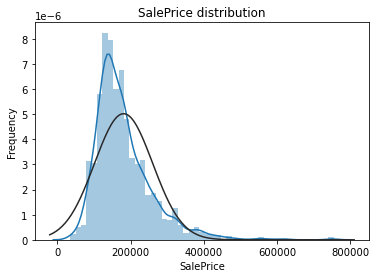

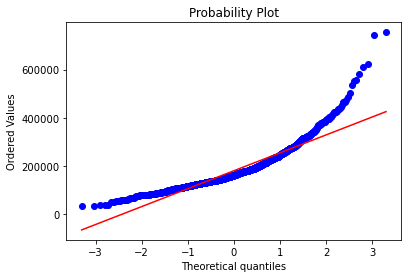

In [14]:
sns.distplot(df['SalePrice'] , fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
# QQ Plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()


In [15]:
# Skewness
df['SalePrice'].skew()

1.8828757597682129

In [16]:
# Kurtosis
df['SalePrice'].kurt()

6.536281860064529

The variable is thus skewed. We will use logarithmic transformation on the target variable after completing the eda.

### Missing value treatment

In [17]:
# Let's check the %age of missing values in the variables those have missing values
missing = df.isnull().sum()/df.shape[0]*100
missing[missing!=0].sort_values(ascending = False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

Looking at the missing values and the variables, I decide that we are going to drop all the variables greater than 15% of the missing values as the variables seem little important and have missing values.

In [18]:
df.drop(list(missing[missing > 17].index), axis = 1, inplace = True)

In [19]:
df.shape

(1460, 74)

In [20]:
missing = df.isnull().sum()/df.shape[0]*100
missing[missing!=0].sort_values(ascending = False)

GarageCond      5.547945
GarageQual      5.547945
GarageFinish    5.547945
GarageYrBlt     5.547945
GarageType      5.547945
BsmtFinType2    2.602740
BsmtExposure    2.602740
BsmtFinType1    2.534247
BsmtCond        2.534247
BsmtQual        2.534247
MasVnrArea      0.547945
MasVnrType      0.547945
Electrical      0.068493
dtype: float64

#### Another interesting thing to notice is that the Garage variables have same number of missing values and Basement variables also have the same number of missing values.

In [21]:
df[df.GarageQual.isnull()].head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
39,90,RL,6040,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,0,June,2008,WD,AdjLand,82000
48,190,RM,4456,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,Gd,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,102,0,0,0,0,June,2009,New,Partial,113000
78,90,RL,10778,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,TA,N,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,0,April,2010,WD,Normal,136500
88,50,C (all),8470,Pave,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,0,October,2009,ConLD,Abnorml,85000
89,20,RL,8070,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,Ex,Y,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,0,August,2007,WD,Normal,123600


Looking at the datapoints where the Garage varaibles are null, I see the area is zero. This means that the appartment has no garage. Let's check the variables individually to see what we want to do with them.

In [22]:
df["GarageCond"].value_counts(dropna = False)

TA     1326
NaN      81
Fa       35
Gd        9
Po        7
Ex        2
Name: GarageCond, dtype: int64

Most of the points in GarageCond have the same value, TA. This means that there is very little variation in the column and it's better to drop.

In [23]:
df["GarageQual"].value_counts(dropna = False)

TA     1311
NaN      81
Fa       48
Gd       14
Po        3
Ex        3
Name: GarageQual, dtype: int64

Similarly, GarageQaul can also be dropped.

For garage Year Built, we will check for how many properties it's the same as the property year built.

In [24]:
(df["GarageYrBlt"] == df["YearBuilt"]).sum()

1089

It's same for about 75% of the data and about 5% don't have any garage. Hence we'll drop the column as well/

In [25]:
df["GarageFinish"].value_counts(dropna = False)

Unf    605
RFn    422
Fin    352
NaN     81
Name: GarageFinish, dtype: int64

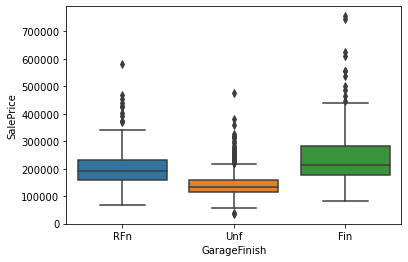

In [26]:
sns.boxplot(data = df, x = "GarageFinish", y = "SalePrice")
plt.show()

In [27]:
df["GarageFinish"].fillna ("No Garage", inplace = True)

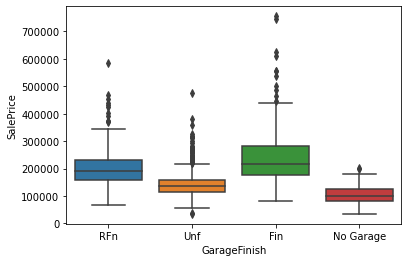

In [28]:
sns.boxplot(data = df, x = "GarageFinish", y = "SalePrice")
plt.show()

In [29]:
df["GarageType"].value_counts(dropna = False)

Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

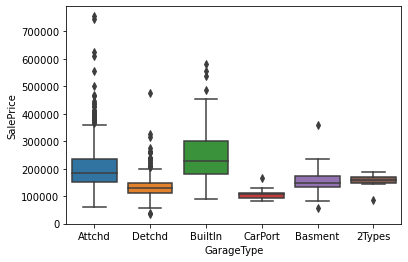

In [30]:
sns.boxplot(data = df, x = "GarageType", y = "SalePrice")
plt.show()

In [31]:
### As some of the level have only a few values, I am going to group the values
df.GarageType[df.GarageType == "BuiltIn"] = "Attchd"
df.GarageType[df.GarageType == "Basement"] = "Attchd"
df.GarageType[df.GarageType == "2Types"] = "Attchd"
df.GarageType[df.GarageType == "CarPort"] = "Detchd"
df.GarageType.fillna("No Garage", inplace = True)

I am going to introduce a new variable called Garage, which will present whether a property have a Garage or not. I am doing this so that I can drop the "No Garage" from Garage Type and Garage Finish while making dummy variables

#### Let's check out the basement variables now

In [32]:
df["BsmtFinType1"].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [33]:
df["BsmtFinType1"].fillna("No Basement", inplace = True)

In [34]:
df["BsmtFinType2"].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [35]:
df["BsmtExposure"].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [36]:
df.BsmtExposure.fillna("No Basement", inplace = True)

In [37]:
df["BsmtCond"].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [38]:
df["BsmtQual"].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [39]:
df.BsmtQual.fillna("No Basement", inplace = True)

In [40]:
df['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [41]:
df['MasVnrArea'].fillna(df['MasVnrArea'].median(), inplace = True)

In [42]:
df['MasVnrType'].value_counts(dropna = False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [43]:
df['MasVnrType'].fillna('None', inplace = True)

In [44]:
df['Electrical'].value_counts(dropna = False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [45]:
df['Electrical'] = df['Electrical'].apply(lambda x: "Other" if x!='SBrkr' else x)

In [46]:
missing = df.isnull().sum()/df.shape[0]*100
missing = missing[missing!=0].sort_values(ascending = False)

In [47]:
missing

GarageCond      5.547945
GarageQual      5.547945
GarageYrBlt     5.547945
BsmtFinType2    2.602740
BsmtCond        2.534247
dtype: float64

In [48]:
df.drop(list(missing.index), axis = 1, inplace = True)

In [49]:
df.isnull().sum().sum()

0

In [50]:
### We are now going to convert years to age so that they can be used in the regression
df['YearBuilt_Old'] = df.YearBuilt.max() - df.YearBuilt
df['YearRemodAdd_Old'] = df.YearRemodAdd.max() - df.YearRemodAdd
df['YrSold_Old'] = df.YrSold.max()-df.YrSold
df[['YearBuilt','YearRemodAdd','YrSold','YearBuilt_Old','YearRemodAdd_Old','YrSold_Old']].head(10) 

,YearBuilt,YearRemodAdd,YrSold,YearBuilt_Old,YearRemodAdd_Old,YrSold_Old
0,2003,2003,2008,7,7,2
1,1976,1976,2007,34,34,3
2,2001,2002,2008,9,8,2
3,1915,1970,2006,95,40,4
4,2000,2000,2008,10,10,2
5,1993,1995,2009,17,15,1
6,2004,2005,2007,6,5,3
7,1973,1973,2009,37,37,1
8,1931,1950,2008,79,60,2
9,1939,1950,2008,71,60,2


In [51]:
## We are now going to drop the original variables
df = df.drop(['YearBuilt','YearRemodAdd','YrSold'],axis= 1)

## Outlier treatment

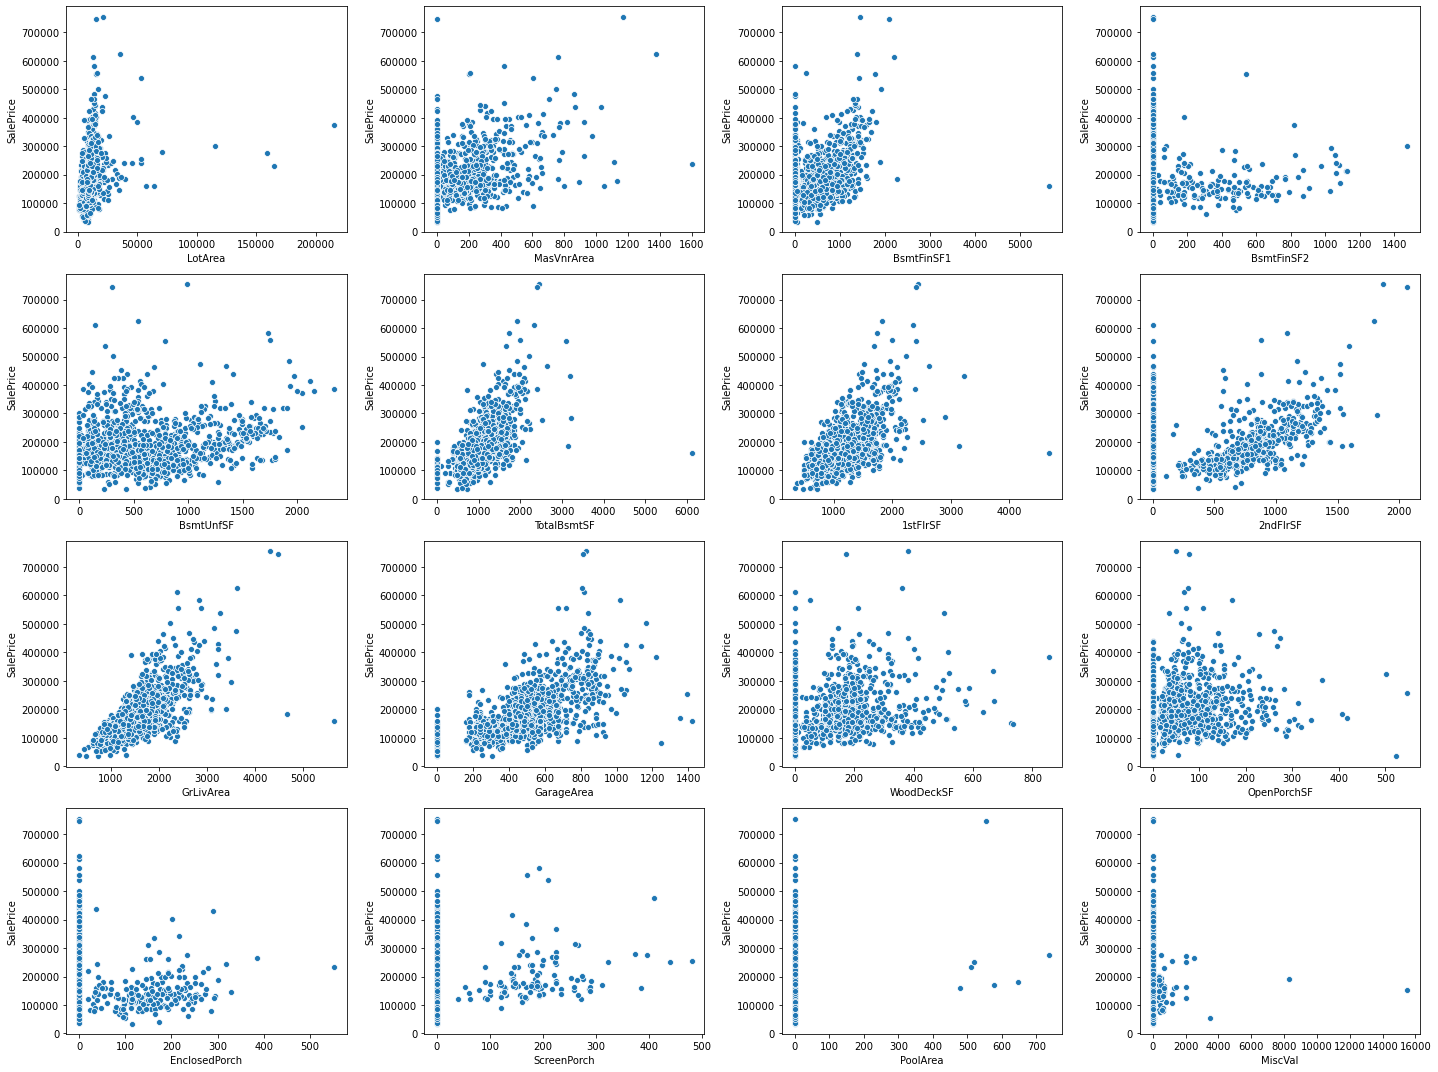

In [52]:
plt.figure(figsize = [20,15])
plt.subplot(4,4,1)
sns.scatterplot(data = df, x = 'LotArea', y = 'SalePrice')
plt.subplot(4,4,2)
sns.scatterplot(data = df, x = 'MasVnrArea', y = 'SalePrice')
plt.subplot(4,4,3)
sns.scatterplot(data = df, x = 'BsmtFinSF1', y = 'SalePrice')
plt.subplot(4,4,4)
sns.scatterplot(data = df, x = 'BsmtFinSF2', y = 'SalePrice')
plt.subplot(4,4,5)
sns.scatterplot(data = df, x = 'BsmtUnfSF', y = 'SalePrice')
plt.subplot(4,4,6)
sns.scatterplot(data = df, x = 'TotalBsmtSF', y = 'SalePrice')
plt.subplot(4,4,7)
sns.scatterplot(data = df, x = '1stFlrSF', y = 'SalePrice')
plt.subplot(4,4,8)
sns.scatterplot(data = df, x = '2ndFlrSF', y = 'SalePrice')
plt.subplot(4,4,9)
sns.scatterplot(data = df, x = 'GrLivArea', y = 'SalePrice')
plt.subplot(4,4,10)
sns.scatterplot(data = df, x = 'GarageArea', y = 'SalePrice')
plt.subplot(4,4,11)
sns.scatterplot(data = df, x = 'WoodDeckSF', y = 'SalePrice')
plt.subplot(4,4,12)
sns.scatterplot(data = df, x = 'OpenPorchSF', y = 'SalePrice')
plt.subplot(4,4,13)
sns.scatterplot(data = df, x = 'EnclosedPorch', y = 'SalePrice')
plt.subplot(4,4,14)
sns.scatterplot(data = df, x = 'ScreenPorch', y = 'SalePrice')
plt.subplot(4,4,15)
sns.scatterplot(data = df, x = 'PoolArea', y = 'SalePrice')
plt.subplot(4,4,16)
sns.scatterplot(data = df, x = 'MiscVal', y = 'SalePrice')
plt.tight_layout()
plt.show()

We are going to cap the variables to deal with outliers


In [53]:
df.LotArea[df.LotArea > 80000] = 80000
df.MasVnrArea[df.MasVnrArea > 1400] = 1400
df.BsmtFinSF1[df.BsmtFinSF1 > 2000] = 2000
df.BsmtFinSF2[df.BsmtFinSF2 > 1200] = 1200
df.TotalBsmtSF[df.TotalBsmtSF > 3200] = 3200
df['1stFlrSF'][df['1stFlrSF'] > 3200] = 3200
df['GrLivArea'][df['GrLivArea'] > 4000] = 4000
df.GarageArea[df.GarageArea > 1200] = 1000
df.OpenPorchSF[df.OpenPorchSF > 420] = 400
df.EnclosedPorch[df.EnclosedPorch > 350] = 350
df.MiscVal[df.MiscVal > 4000] = 4000

# I am going to drop the pool area column as 99% of the house have no pool at all
df.drop('PoolArea', axis = 1, inplace = True)

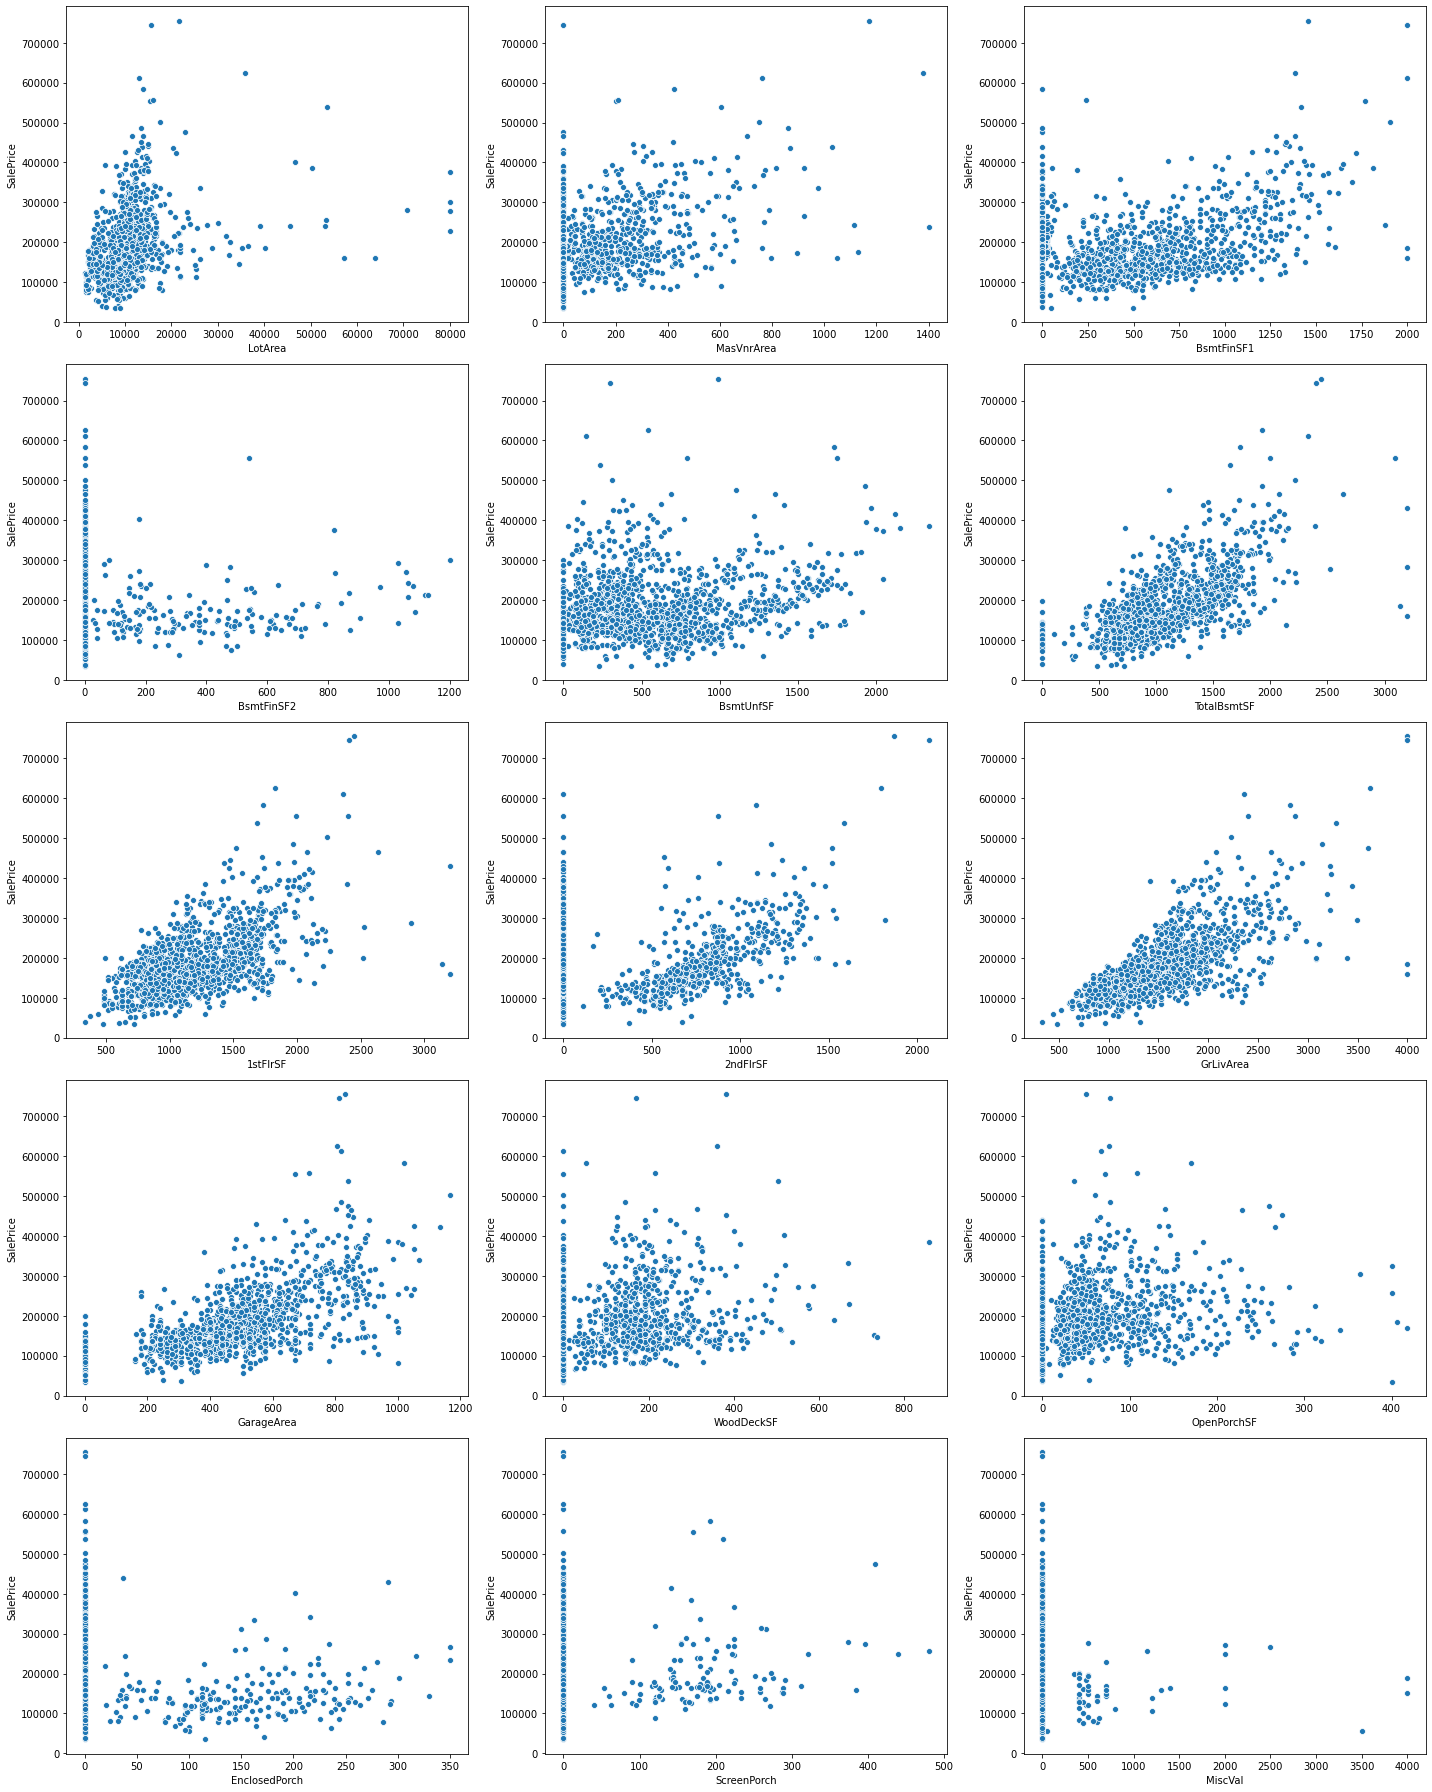

In [54]:
plt.figure(figsize = [20,25])
plt.subplot(5,3,1)
sns.scatterplot(data = df, x = 'LotArea', y = 'SalePrice')
plt.subplot(5,3,2)
sns.scatterplot(data = df, x = 'MasVnrArea', y = 'SalePrice')
plt.subplot(5,3,3)
sns.scatterplot(data = df, x = 'BsmtFinSF1', y = 'SalePrice')
plt.subplot(5,3,4)
sns.scatterplot(data = df, x = 'BsmtFinSF2', y = 'SalePrice')
plt.subplot(5,3,5)
sns.scatterplot(data = df, x = 'BsmtUnfSF', y = 'SalePrice')
plt.subplot(5,3,6)
sns.scatterplot(data = df, x = 'TotalBsmtSF', y = 'SalePrice')
plt.subplot(5,3,7)
sns.scatterplot(data = df, x = '1stFlrSF', y = 'SalePrice')
plt.subplot(5,3,8)
sns.scatterplot(data = df, x = '2ndFlrSF', y = 'SalePrice')
plt.subplot(5,3,9)
sns.scatterplot(data = df, x = 'GrLivArea', y = 'SalePrice')
plt.subplot(5,3,10)
sns.scatterplot(data = df, x = 'GarageArea', y = 'SalePrice')
plt.subplot(5,3,11)
sns.scatterplot(data = df, x = 'WoodDeckSF', y = 'SalePrice')
plt.subplot(5,3,12)
sns.scatterplot(data = df, x = 'OpenPorchSF', y = 'SalePrice')
plt.subplot(5,3,13)
sns.scatterplot(data = df, x = 'EnclosedPorch', y = 'SalePrice')
plt.subplot(5,3,14)
sns.scatterplot(data = df, x = 'ScreenPorch', y = 'SalePrice')
plt.subplot(5,3,15)
sns.scatterplot(data = df, x = 'MiscVal', y = 'SalePrice')
plt.tight_layout()
plt.show()


### The plots look much better!

In [55]:
df.shape

(1460, 68)

### Data type correction

There are some variables in the data with are ordinal variables instead of Nominal variables and we'll convert these to numercials for regression purpose.

In [56]:
df['ExterQual'] = df.ExterQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['ExterCond'] = df.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['BsmtQual'] = df.BsmtQual.map({'No Basement':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['BsmtExposure'] = df.BsmtExposure.map({'No Basement':0, 'No':0, 'Mn':1, 'Av':2, 'Gd':3})
df['BsmtFinType1'] = df.BsmtFinType1.map({'No Basement':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
df['HeatingQC'] = df.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['KitchenQual'] = df.KitchenQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df['GarageFinish'] = df.GarageFinish.map({'No Garage':0,'Unf':1,'RFn':2,'Fin':3})

## Exploratory Data Analysis

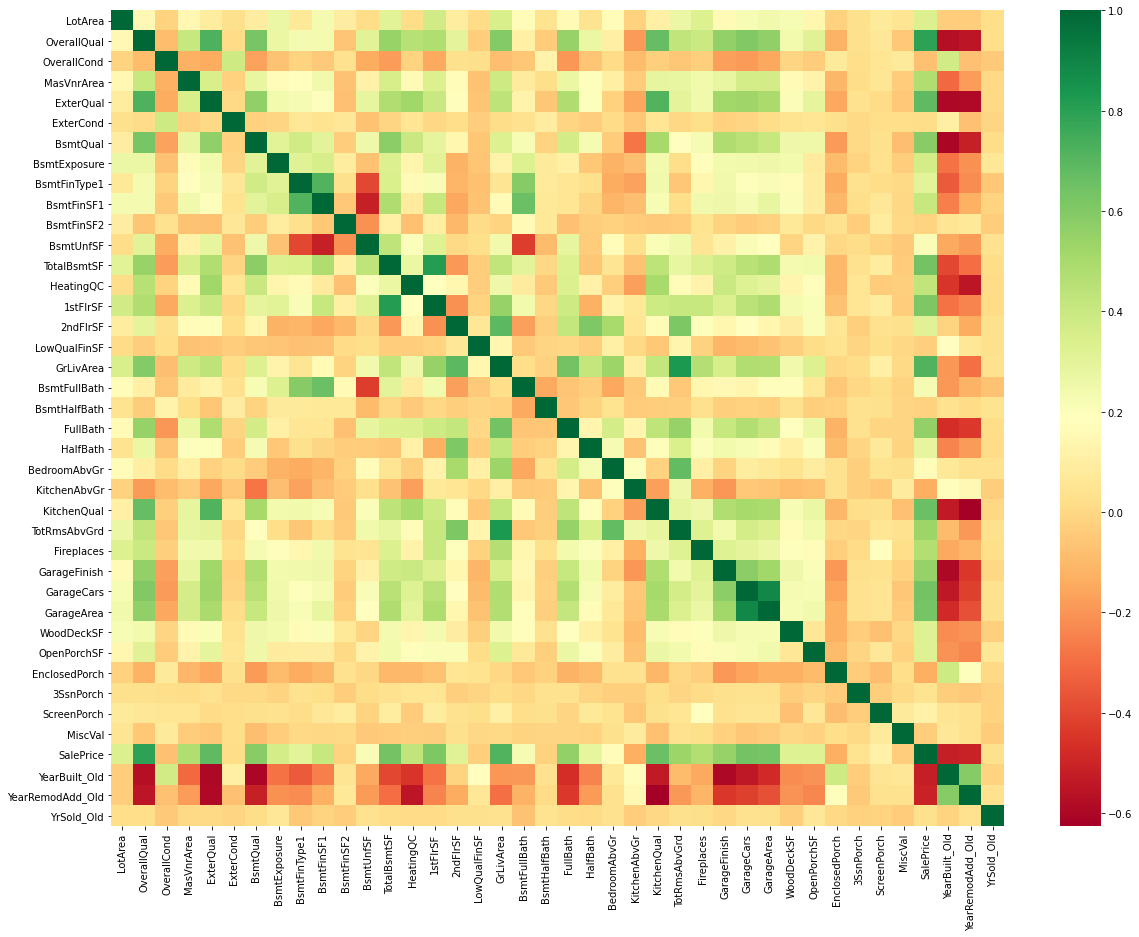

In [57]:
plt.figure(figsize = [20, 15])
sns.heatmap(df.corr(), cmap = "RdYlGn")
plt.show()

We can see quite a few correlations. Let's check the top positive and the to negative correlation with SalePrice

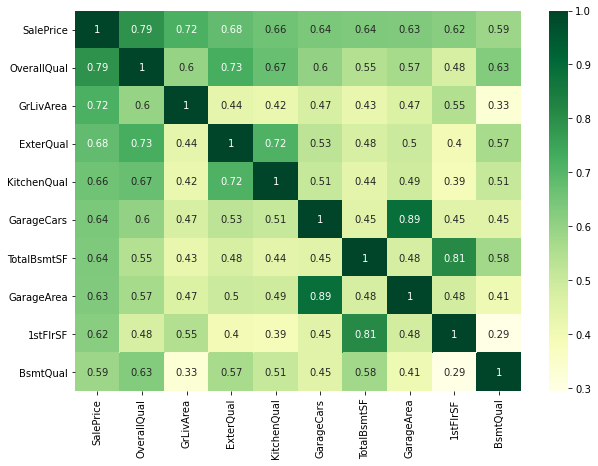

In [58]:
plt.figure(figsize = [10,7])
var = df.corr().nlargest(10, 'SalePrice')['SalePrice'].index
coef = np.corrcoef(df[var].values.T)
sns.heatmap(coef, xticklabels = var, yticklabels = var, annot = True, cmap = "YlGn")
plt.show()

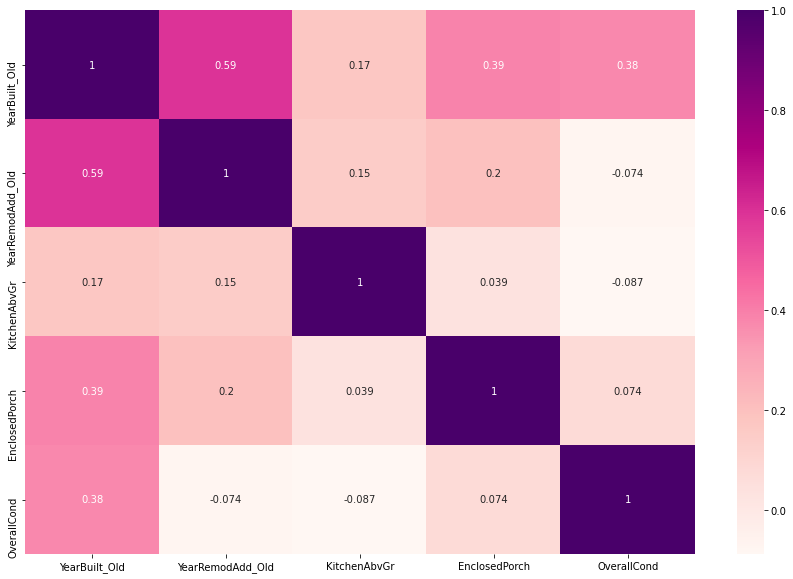

In [59]:
plt.figure(figsize = [15,10])
var = df.corr().nsmallest(5, 'SalePrice')['SalePrice'].index
coef = np.corrcoef(df[var].values.T)
sns.heatmap(coef, xticklabels = var, yticklabels = var, annot = True, cmap = "RdPu")
plt.show()

We see from the heatmaps that SalePrice doesn't have a negative correlation any of the numercial variables.

And from the variables, these seem like important variables: - 

    - SalePrice
    - OverallQual
    - GrLivArea
    - ExterQual
    - KitchenQual
    - GarageCars
    - TotalBsmtSF
    - GarageArea
    - 1stFlrSF
    - BsmtQual

#### Categorical Variables

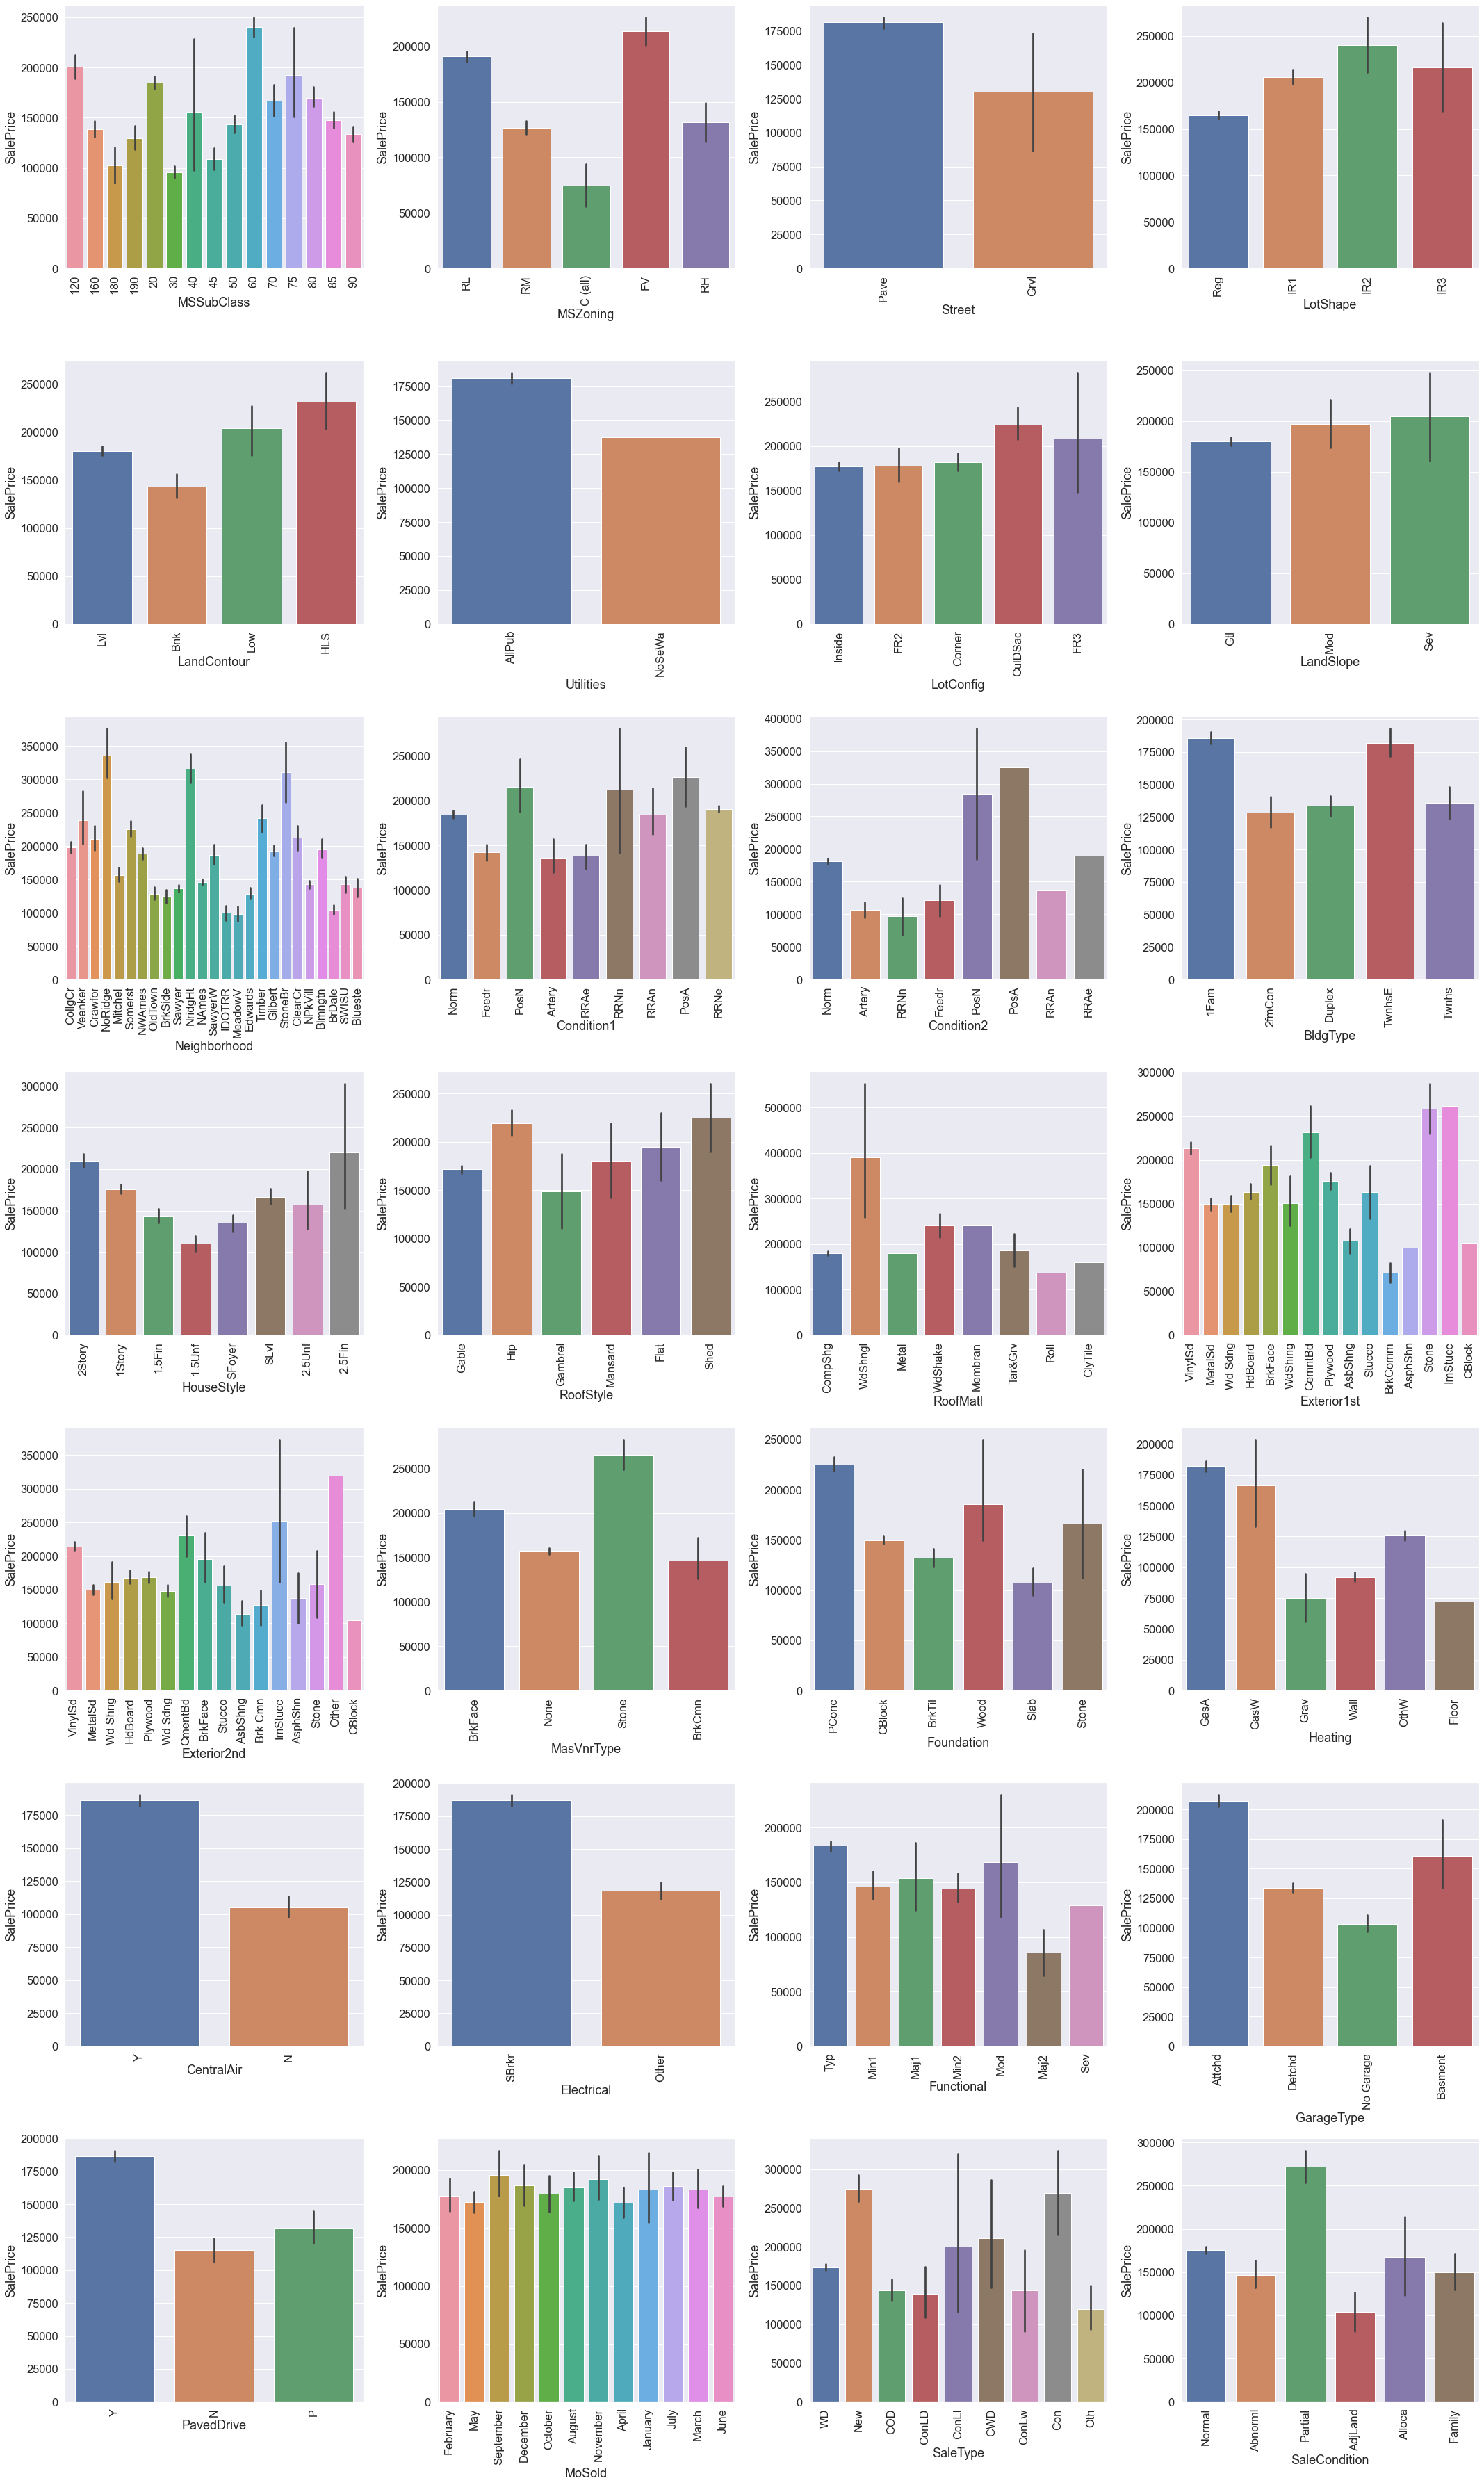

In [60]:
cat = df.select_dtypes('object').columns
c = 1
plt.figure(figsize = [30,50])
sns.set(font_scale=1.5)

for i in cat:
    plt.subplot(7, 4, c)
    sns.barplot(data = df, x = i, y = 'SalePrice', label = i, estimator = np.mean )
    plt.xticks(rotation = 90)
    c += 1
plt.tight_layout()
plt.show()


#### The above graph show the mean sale price for different categories for different variables.


### Creating Dummy variables and joining with the original data

In [61]:
dummy = pd.get_dummies(df[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition', 'MoSold',
                          'CentralAir', 'LotShape', 'MSSubClass']], drop_first = True)

In [62]:
df = pd.concat([df,dummy],axis='columns')

df = df.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition', 'MoSold', 
              'CentralAir', 'LotShape', 'MSSubClass'],axis='columns')

#### I left some variables here as I could see the have very less variance and hence I am going to drop them from my analysis.

In [63]:
df.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [64]:
df.drop('Utilities', axis = 1, inplace = True)

In [65]:
df.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [66]:
df.drop('Street', axis = 1, inplace = True)

In [67]:
df['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [68]:
df.drop('LandSlope', axis = 1, inplace = True)

In [69]:
df.head()

,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,YearBuilt_Old,YearRemodAdd_Old,YrSold_Old,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Basment,GarageType_Detchd,GarageType_No Garage,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MoSold_August,MoSold_December,MoSold_February,MoSold_January,MoSold_July,MoSold_June,MoSold_March,MoSold_May,MoSold_November,MoSold_October,MoSold_September,CentralAir_Y,LotShape_IR2,LotShape_IR3,LotShape_Reg,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
0,8450,7,5,196.0,4,3,4,0,6,706,0,150,856,5,856,854,0,1710,1,0,2,1,3,1,4,8,0,2,2,548,0,61,0,0,0,0,208500,7,7,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,9600,6,8,0.0,3,3,4,3,5,978,0,284,1262,5,1262,0,0,1262,0,1,2,0,3,1,3,6,1,2,2,460,298,0,0,0,0,0,181500,34,34,3,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

### We'll now transform the target variable to log

In [70]:
df['SalePrice'] = np.log(df['SalePrice'])

### Let's split the dataset now

In [71]:
df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=42)

### We'll also scale the numerical variables

In [72]:
df.columns[df.nunique()>2]

Index(['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageFinish', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'SalePrice', 'YearBuilt_Old',
       'YearRemodAdd_Old', 'YrSold_Old'],
      dtype='object')

In [73]:
number_col = ['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageFinish', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'YearBuilt_Old',
       'YearRemodAdd_Old', 'YrSold_Old']
scaler = MinMaxScaler()
df_train[number_col] = scaler.fit_transform(df_train[number_col])
df_test[number_col] = scaler.transform(df_test[number_col])

### Splitting x and y

In [74]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [75]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [76]:
X_train.shape

(1021, 208)

#### Using RFE to get the top 50 features

In [77]:
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,50)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=50)

In [78]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

In [79]:
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

In [80]:
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

### Starting with Lasso Regression

In [81]:
lm = Lasso(alpha=0.005)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8380371880071851
0.8497317791207684


In [82]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = df_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter))

[('LotArea', 11.089),
 ('OverallQual', 0.0),
 ('OverallCond', 0.789),
 ('MasVnrArea', 0.04),
 ('ExterQual', 0.146),
 ('ExterCond', 0.0),
 ('BsmtQual', 0.164),
 ('BsmtExposure', 0.0),
 ('BsmtFinType1', 0.0),
 ('BsmtFinSF1', 0.029),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.0),
 ('TotalBsmtSF', -0.0),
 ('HeatingQC', 0.668),
 ('1stFlrSF', -0.0),
 ('2ndFlrSF', 0.139),
 ('LowQualFinSF', 0.316),
 ('GrLivArea', 0.048),
 ('BsmtFullBath', 0.0),
 ('BsmtHalfBath', 0.0),
 ('FullBath', -0.208),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', -0.0),
 ('KitchenAbvGr', 0.025),
 ('KitchenQual', -0.075),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', 0.0),
 ('GarageFinish', -0.0),
 ('GarageCars', 0.0),
 ('GarageArea', -0.0),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', -0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.0),
 ('MiscVal', 0.0),
 ('YearBuilt_Old', -0.0),
 ('YearRemodAdd_Old', -0.0),
 ('YrSold_Old', 0.0),
 ('MSZoning_FV', -0.0),
 ('MSZoning_RH', -0.0),
 ('MSZoning_RL', -0.0),
 ('MSZoning_RM', -0.

### USing grid search for K-fold crossvalidation`

In [83]:
folds = KFold(n_splits=10, shuffle=True, random_state=42)

hyper_param = {'alpha':[0.001, 0.01, 0.05, 0.1, 1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True
                       )

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.6s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.05, 0.1, 1.0, 5.0, 10.0,
                                   20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [84]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004683,0.001338,0.001993,7.524363e-07,0.001,{'alpha': 0.001},0.896166,0.906795,0.877646,0.906958,0.884702,0.728292,0.844458,0.734017,0.917216,0.874093,0.857034,0.065931,1,0.876222,0.875622,0.878005,0.875268,0.878243,0.893554,0.880702,0.891319,0.871296,0.878432,0.879866,0.006732
1,0.003688,0.000898,0.001894,2.990038e-04,0.010,{'alpha': 0.01},0.793394,0.805650,0.814197,0.810604,0.793352,0.762510,0.752005,0.713123,0.807703,0.784524,0.783706,0.030552,2,0.795881,0.792465,0.796695,0.792047,0.794671,0.808563,0.804083,0.812093,0.782039,0.794445,0.797298,0.008325
2,0.003687,0.000779,0.001993,6.312820e-04,0.050,{'alpha': 0.05},0.003167,0.005101,-0.000364,-0.015013,-0.019962,-0.008664,0.023788,0.018089,-0.029558,-0.016388,-0.003980,0.016162,3,0.004061,0.013227,0.006611,0.000000,0.007196,0.005452,0.029708,0.019508,0.002172,0.000991,0.008893,0.008915
3,0.004287,0.001001,0.002091,2.958013e-04,0.100,{'alpha': 0.1},-0.000648,-0.003673,-0.007997,-0.015013,-0.025158,-0.014054,-0.004954,-0.000046,-0.031006,-0.017218,-0.011977,0.009908,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.004188,0.000871,0.002092,6.954384e-04,1.000,{'alpha': 1.0},-0.000648,-0.003673,-0.007997,-0.015013,-0.025158,-0.014054,-0.004954,-0.000046,-0.031006,-0.017218,-0.011977,0.009908,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


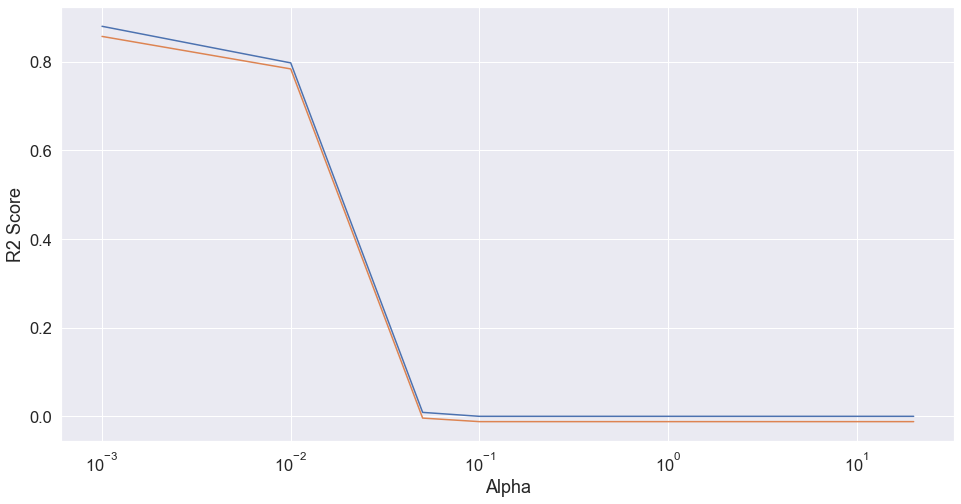

In [85]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [86]:
# Checking the best parameter
model_cv.best_params_

{'alpha': 0.001}

In [87]:
## The best value of alpha is coming out to be 0.01. Let fit a lasso regression model using that.
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print("Train Accuracy is: ", r2_score(y_true=y_train, y_pred=y_train_pred))
print("Test Accuracy is: ", r2_score(y_true=y_test, y_pred=y_test_pred))

Train Accuracy is:  0.8787777412375978
Test Accuracy is:  0.8965518235532065


### That's a very decent score for both test and train datasets.

Let's see which 10 variables are contributing the most

In [88]:
model_param = list(lasso.coef_)
model_param.insert(0, lasso.intercept_)
cols = df_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Feature','Coef']

In [89]:
lasso_important = lasso_coef.sort_values(by='Coef',ascending=False).head(10)
lasso_important

,Feature,Coef
0,LotArea,10.882975
13,HeatingQC,0.879110
2,OverallCond,0.654185
3,MasVnrArea,0.330532
16,LowQualFinSF,0.322977
9,BsmtFinSF1,0.197476
6,BsmtQual,0.171140
15,2ndFlrSF,0.121114
4,ExterQual,0.110673
21,HalfBath,0.092960


#### Lot area is coming out to be the most important variable out of all which sounds reasonable as the prices are definitely directy proportional to the area of the house

### Time to try the Ridge regression

In [90]:
ridge = Ridge(alpha=0.005)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print("Train Accuracy is: ", r2_score(y_true=y_train, y_pred=y_train_pred))
print("Test Accuracy is: ", r2_score(y_true=y_test, y_pred=y_test_pred))

Train Accuracy is:  0.9218092086488073
Test Accuracy is:  0.8793559435294389


### The scores look great already, let's see if we can do any improvement by doing a cross validation

In [91]:
folds  = KFold(n_splits=10, shuffle=True, random_state=42)

hyper_param = {'alpha':[0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0, 20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,
                        param_grid=hyper_param,
                        scoring='r2',
                        cv=folds,
                        verbose=1,
                        return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 5.0,
                                   10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [92]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.004190,0.000868,0.002288,6.387353e-04,0.001,{'alpha': 0.001},0.920803,0.916850,0.907701,0.901267,0.884242,0.929245,0.856563,0.717777,0.901917,0.894809,0.883117,0.058441,1,0.921690,0.922577,0.922827,0.923123,0.925796,0.921462,0.927047,0.926850,0.922032,0.924942,0.923835,0.002027
1,0.002791,0.000399,0.001993,4.702349e-07,0.010,{'alpha': 0.01},0.919918,0.918643,0.797404,0.901412,0.885083,0.812928,0.746731,0.721752,0.921562,0.894189,0.851962,0.071946,7,0.920003,0.920734,0.921067,0.921373,0.923988,0.919433,0.925395,0.926778,0.920200,0.923133,0.922210,0.002363
2,0.003788,0.000747,0.002292,4.570981e-04,0.050,{'alpha': 0.05},0.917966,0.920271,0.788590,0.902159,0.886569,0.747294,0.739088,0.724695,0.931196,0.892066,0.844989,0.080031,9,0.916337,0.916781,0.917507,0.917529,0.920107,0.915991,0.921964,0.925667,0.914438,0.919314,0.918564,0.003145
3,0.003090,0.000830,0.002094,2.992111e-04,0.100,{'alpha': 0.1},0.916768,0.920403,0.812182,0.902873,0.887681,0.728928,0.766384,0.725206,0.931595,0.890268,0.848229,0.077802,8,0.913179,0.913380,0.914595,0.914235,0.916774,0.914212,0.919100,0.923751,0.910694,0.916039,0.915596,0.003463
4,0.003191,0.000397,0.001595,4.887806e-04,0.200,{'alpha': 0.2},0.915556,0.919653,0.842707,0.904203,0.889334,0.717753,0.801566,0.725403,0.931133,0.887762,0.853507,0.075454,6,0.908724,0.908656,0.910498,0.909632,0.912115,0.912651,0.914966,0.920296,0.905817,0.911502,0.911486,0.003790


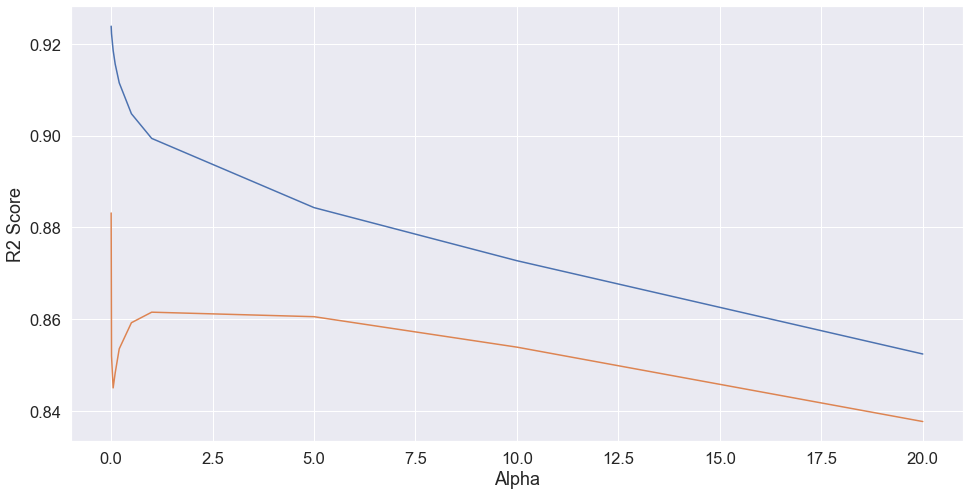

In [93]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

In [94]:
#Checking the best parameter
model_cv.best_params_

{'alpha': 0.001}

In [95]:
ridge = Ridge(alpha = 5)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print("Train Accuracy is: ", r2_score(y_true=y_train, y_pred=y_train_pred))
print("Test Accuracy is: ", r2_score(y_true=y_test, y_pred=y_test_pred))

Train Accuracy is:  0.8846192430316406
Test Accuracy is:  0.8904441601778323


### This does a great job, even better than our lasso model.

#### Checking which variables contribute the most

In [96]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0, ridge.intercept_)
cols = df_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature','Coef']

In [97]:
ridge_important = ridge_coef.sort_values(by='Coef',ascending=False).head(10) 
ridge_important

,Feature,Coef
0,LotArea,10.751970
2,OverallCond,0.488901
13,HeatingQC,0.382850
3,MasVnrArea,0.280462
11,BsmtUnfSF,0.266074
16,LowQualFinSF,0.258804
6,BsmtQual,0.246374
10,BsmtFinSF2,0.218096
4,ExterQual,0.188173
9,BsmtFinSF1,0.184116


# Summary :- 

#### For lasso regression :-
    - Optimal value of alpha: 0.01
    - Train Accuracy is:  0.8870164725282308
    - Test Accuracy is:  0.8729268890901862
    - 10 most important variables are coming out to be - LotArea, OverallCond, BsmtFinType1, BsmtExposure, BsmtFinSF1, MasVnrArea, BsmtUnfSF, BsmtHalfBath, OverallQual, YearRemodAdd_Old

#### For ridge regression :-
    - Optimal value of alpha: 5.0
    - Train Accuracy is:  0.9213866751238488
    - Test Accuracy is:  0.9043347852548373
    - 10 most important variables are coming out to be - LotArea, OverallCond, BsmtFullBath, MasVnrArea, 2ndFlrSF, LowQualFinSF, BsmtFinSF2, GarageArea, Fireplaces, Neighborhood_Timber
    

#### According to both the models, LotArea, Overall Condition Score, MasVnrArea are coming out to be most important variables that decide the price of the house (All of them affecting positively

# Subjective Questions

In [98]:
ridge = Ridge(alpha=10)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
print('Ridge')
print("Train Accuracy is: ", r2_score(y_true=y_train, y_pred=y_train_pred))
print("Test Accuracy is: ", r2_score(y_true=y_test, y_pred=y_test_pred))
model_parameter = list(ridge.coef_)
model_parameter.insert(0, ridge.intercept_)
cols = df_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feature','Coef']
ridge_important = ridge_coef.sort_values(by='Coef',ascending=False).head(10)
print(list(ridge_important['Feature']))

Ridge
Train Accuracy is:  0.8741131930140211
Test Accuracy is:  0.8824422595982
['LotArea', 'OverallCond', 'HeatingQC', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtQual', 'MasVnrArea', 'ExterQual', 'BsmtFinSF2', 'BsmtFinSF1']


In [99]:
lm = Lasso(alpha=0.002)
lm.fit(X_train,y_train)
y_train_pred = lm.predict(X_train)
y_test_pred  = lm.predict(X_test)
print('Lasso')
print("Train Accuracy is: ", r2_score(y_true=y_train, y_pred=y_train_pred))
print("Test Accuracy is: ", r2_score(y_true=y_test, y_pred=y_test_pred))

model_param = list(lasso.coef_)
model_param.insert(0, lasso.intercept_)
cols = df_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Feature','Coef']
lasso_important = lasso_coef.sort_values(by='Coef',ascending=False).head(10)
print(list(lasso_important['Feature']))


Lasso
Train Accuracy is:  0.8675531885083233
Test Accuracy is:  0.8849423786840449
['LotArea', 'HeatingQC', 'OverallCond', 'MasVnrArea', 'LowQualFinSF', 'BsmtFinSF1', 'BsmtQual', '2ndFlrSF', 'ExterQual', 'HalfBath']
